# Verify models for visual proprioception

Verifies a regression model for visual proprioception, as trained in the notebook Train_VisualProprioception

The encoding and the regressor is specified in an experiment of type visual_proprioception. 

In [1]:
import sys
sys.path.append("..")
from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import pathlib
from pprint import pprint
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

from sensorprocessing import sp_conv_vae, sp_propriotuned_cnn
# from robot.al5d_position_controller import RobotPosition

from visual_proprioception.visproprio_helper import load_demonstrations_as_proprioception_training, get_visual_proprioception_sp
from visual_proprioception.visproprio_models import VisProprio_SimpleMLPRegression

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml
Using device: cuda


In [2]:
experiment = "visual_proprioception"

# the latent space 128 ones
# run = "vp_aruco_128"
run = "vp_convvae_128"
# run = "vp_ptun_vgg19_128"
# run = "vp_ptun_resnet50_128"

# the latent space 256 ones
# run = "vp_convvae_256"
# run = "vp_ptun_vgg19_256"
# run = "vp_ptun_resnet50_256"
exp = Config().get_experiment(experiment, run)
pprint(exp)

# Create the sp object described in the experiment
spexp = Config().get_experiment(exp["sp_experiment"], exp["sp_run"])
sp = get_visual_proprioception_sp(exp, device)

***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\visual_proprioception\vp_convvae_128_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: visual_proprioception/vp_convvae_128 successfully loaded
Experiment:
    batch_size: 32
    data_dir: c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\visual_proprioception\vp_convvae_128
    encoding_size: 128
    epochs: 100
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\visual_proprioception\vp_convvae_128.yaml
    experiment_name: visual_proprioception
    loss: MSE
    name: conv-vae-128
    output_size: 6
    proprioception_input_file: train_inputs.pt
    proprioception_mlp_model_file: proprioception_mlp.pth
    proprioception_target_file: train_targets.pt
    proprioception_test_input_file: test_inputs.pt
    proprioception_test_target_file: test_ta

In [3]:
# Create the regression model and load in the previously saved weights

model = VisProprio_SimpleMLPRegression(exp)
modelfile = pathlib.Path(exp["data_dir"], 
                         exp["proprioception_mlp_model_file"])
model.load_state_dict(torch.load(modelfile))
model.to(device)

C:\Users\lboloni\AppData\Local\Temp\ipykernel_62492\67854235.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelfile))


VisProprio_SimpleMLPRegression(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)

## Accuracy in time multigraph
Visualize the accuracy of the proprioception on the testing task, by plotting the ground truth. 

In [5]:

proprioception_input_file = pathlib.Path(
    exp["data_dir"], exp["proprioception_test_input_file"])
proprioception_target_file = pathlib.Path(
    exp["data_dir"], exp["proprioception_test_target_file"])

tr = load_demonstrations_as_proprioception_training(
    sp, exp, spexp, "validation_data", proprioception_input_file, proprioception_target_file, device=device
)

inputs = tr["inputs"] # these are actually tensors
targets = tr["targets"]
print(f"There are {inputs.shape[0]} data points")

There are 986 data points


In [8]:
no_from = 0
no_to = inputs.shape[0]
ypred = []
y = []
t = []
with torch.no_grad():
    for i in range(no_from, no_to):
        x = inputs[i]
        x = x.to(device)
        predictions = model(torch.unsqueeze(x, dim=0))
        # append the data 
        t.append(i)
        y.append(targets[i].numpy())
        ypred.append(predictions[0].cpu().numpy())

In [9]:
ypred = np.array(ypred)
y = np.array(y)
t = np.array(t)

Create a graph with the six degrees of freedom, predicted and real value

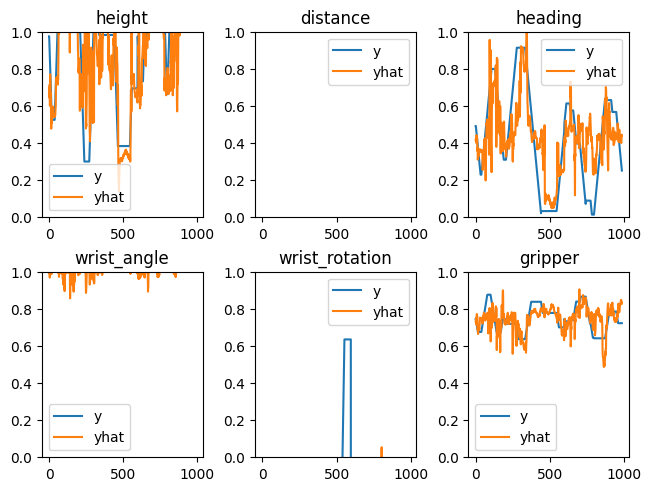

In [10]:
fig, axs = plt.subplots(2,3, constrained_layout=True)
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//3, i%3] 
    ax.set_ylim(0, 1)
    ax.plot(t, y[:,i], label="y")
    ax.plot(t, ypred[:,i], label="yhat")
    ax.legend()
    ax.set_title(titles[i])

graphfilename = pathlib.Path(exp["data_dir"], "proprio_error.pdf")
plt.savefig(graphfilename)

In [11]:
POS_MAX = {"height": 5.0, "distance": 10.0, "heading": 90.0, 
               "wrist_angle": 90.0, "wrist_rotation": 75.0 + 90.0, 
               "gripper": 100}

In [12]:
for i, fld in enumerate(POS_MAX):
    print(i, fld)

0 height
1 distance
2 heading
3 wrist_angle
4 wrist_rotation
5 gripper
